In [1]:
import os
import gzip
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plot
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import PCA
from skbio.stats.composition import clr
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.stats.mstats import gmean
from sklearn.cluster import KMeans as kmeans
from sklearn.cluster import AffinityPropagation 
os.chdir('/home/alexis/UAM/picrust/Mar20/OTUs_99')
biomenet_taxon_results = '/home/alexis/BiomeNet/BiomeNet/taxon_analysis/results/OTUs_99/My_20/'


In [7]:
taxonomy = pd.read_csv('/home/alexis/UAM/qiime/Mar20/OTUs_99/silva_taxonomy.csv', sep ='\t')
taxonomy.set_index('sequence_identifier', inplace = True)
runs = os.listdir(biomenet_taxon_results)
metabosystems_contib = load_metabosystems(runs)
for r in runs:
    metabosystems_contib[r].drop( index = ['0281ce539a44c8b1b059ae85c15e3fab'], inplace = True)
pca_results, taxon_clusters, labels, scores = cluster_pca_taxons(runs, metabosystems_contib)
scores

Converged after 69 iterations.
Converged after 59 iterations.


{'K3_L125': 0.04861756178291574, 'K3_L250': 0.07987183586040399}

In [8]:
metabosystems_contib['K3_L250']
for tax in metabosystems_contib['K3_L250'].index:
    print(tax, taxonomy.loc[tax,'Genus'])

015b00f942c7e2f4c9e06db46c817ece Acinetobacter
04ed749055716405f08554396d62d9cd Acinetobacter
05f85d159631cc9dee015f8f7e5420f5 Sediminibacterium
066435e4a454af2d4d8673e1231706e4 Methylophilus
071f79711bbdde2fd3eb7d654747ed9b Ramlibacter
0e33872a3fe4b1704598808acfae3563 Bosea
11d14478195a36d51737677a396322c7 Sediminibacterium
12d83954270f2202982fac6fd2c2c3f5 Hyphomicrobium
141458448b5097a0ac39eb07451e15b5 Ramlibacter
1be55386fc32b346e10e015496e60afc Methylocystis
1c939b728d70eb1bab0f18e441de5968 Methylocystis
23c7ddf7cf981b12958e8cc5fb5c3214 Brucella
37f7bb4a23468fc0baef6011ad7d2194 Sediminibacterium
3e4a816d5da7c519c457794b95177ac2 Bosea
4a7064f21adc047c4e1ef4379528dff2 Hyphomicrobium
4cb6665992ea91545070bb434af53045 Terrimonas
4d1942ab2822b7932dc710aed9cc7327 Hyphomicrobium
50f0eb01ffa906db1a2c0268f442d019 Hyphomicrobium
51697479c20a3199ddf2b6dc04be3fab Afipia
53924ec3569cfd99e0e04acc9cfa4629 Hyphomicrobium
6025a943ded84f79180041637e0ee966 Hyphomicrobium
6b9addb4fdea71e1f4c7943a6155c1

,V1,V2,V3
0,0.376382,0.197757,0.425861
1,0.330585,0.226908,0.442506
2,0.293119,0.229075,0.477807
3,0.331604,0.324276,0.34412
4,0.310494,0.183911,0.505595


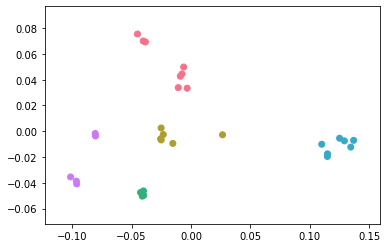

In [9]:
plot_cluster_taxons('K3_L250', metabosystems_contib, labels, pca_results)
taxon_clusters['K3_L250']

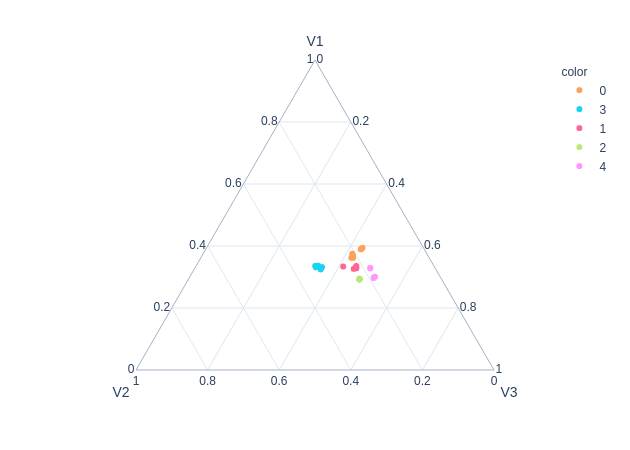

In [10]:
fig = triplot_cluster_taxons('K3_L250', metabosystems_contib, labels)
fig.write_html("Analysis/My_20/triplot.html")
fig.write_image("Analysis/My_20/triplot.png")

In [39]:
metabosystems = metabosystems_contib['K3_L250'].columns[0:3]
subsystems_contrib = pd.read_csv(biomenet_taxon_results+'K3_L250'+'/subnetwork_contrib.tsv', sep = '\t', dtype = 'float64')
subsystems_contrib.set_index('sub', inplace = True)
subsystems_contrib.rename(columns = dict(zip(subsystems_contrib.columns, metabosystems)), inplace = True)
nsubs = len(subsystems_contrib.loc[:,'V1'])

subsystems_dict = {}
for mesysi in metabosystems:
    subsystems_dict[mesysi] = subsystems_contrib.loc[:, mesysi]
    
reaction_contrib = pd.read_csv(biomenet_taxon_results+'K3_L250'+'/reaction_contrib.tsv', sep = '\t')
reaction_contrib.set_index('Reaction', inplace = True)
reaction_contrib.rename(columns = dict(zip(reaction_contrib.columns,
                                           (reaction_contrib.columns.to_numpy().astype('int') + 1))), inplace = True)

EC_reactions = pd.read_csv('/home/alexis/UAM/picrust/default_files/metacyc_rxns_v24_ADDED.csv', sep = '\t')
EC_reactions.set_index('Reaction', inplace = True)

metacyc_pathways = pd.read_csv('/home/alexis/UAM/picrust/default_files/metacyc_path2rxn_struc_filt_pro.txt', sep = '\t', names = ['Pathway', 'Reactions'])
temp = pd.read_csv('/home/alexis/UAM/picrust/default_files/metacyc_pathways_info_prokaryotes_sec_level.tsv', sep = '\t', names = ['Pathway', 'Description'])
#temp = pd.read_csv('default_file/metacyc_pathways_info.txt.gz', compression = 'gzip', sep = '\t', names = ['Pathway', 'Description'])

temp.set_index('Pathway', inplace = True)
metacyc_pathways.set_index('Pathway', inplace = True)
metacyc_pathways = metacyc_pathways.join(temp)


In [40]:
metabosystems_reactions = write_rxns_df(metabosystems, subsystems_dict)
clusters_selection = {0:['V1','V2','V3'], 1:['V1','V2','V3'], 2:['V1','V2','V3']}
cluster_reactions = {}
for cluster in taxon_clusters['K3_L250'].index:
    cluster_reactions[cluster] = pd.DataFrame((metabosystems_reactions.loc[:,clusters_selection[cluster]]*taxon_clusters['K3_L250'].loc[cluster,clusters_selection[cluster]]).sum(1))
    cluster_reactions[cluster].rename(columns = {0:'contrib'}, inplace = True)
    annotate_rxn(cluster, cluster_reactions)
    rxn_to_ec(cluster, cluster_reactions, path = 'Analysis/My_20/EC_metagenome_out/')

written EC-metagenome for 0
written EC-metagenome for 1
written EC-metagenome for 2


In [41]:
cluster_pathways = load_unstrat_pathway(path = 'Analysis/My_20/pathways_out/path_abun_unstrat.tsv.gz')

In [42]:
for path in cluster_pathways['second_level'].index:
    cluster_pathways['second_level_clr'].loc[path, :] = clr(cluster_pathways['second_level'].loc[path,:])

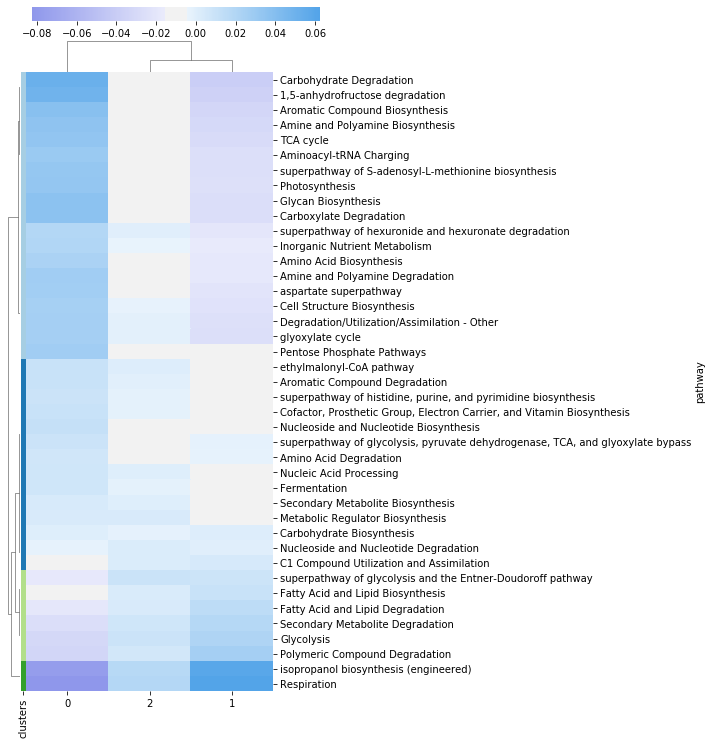

In [43]:
fig = plot_pathway_heatmap(cluster_pathways['second_level_clr'], cmap = sns.diverging_palette(263, 244, s = 79, l = 65, sep = 20, as_cmap = True))
fig.savefig('Analysis/My_20/pathway_heatmap.png')

In [48]:
major_subsystems, min_major_probability = get_major_subsystems(metabosystems, subsystems_contrib)

discriminatory_susbsystems = {}
discriminatory_reactions = {}
discriminatory_pathways = {}
discriminatory_pathways_descrip = {}
major_reactions = {}

for mesysi in metabosystems:
    if mesysi == 'V1':
        discriminatory_susbsystems[mesysi] = major_subsystems[mesysi].copy()
    else:
    get_discriminatory_subsystems(mesysi, major_subsystems, min_major_probability, discriminatory_susbsystems, cutoff = 0.51)
    write_rxns_dict(mesysi, discriminatory_susbsystems, discriminatory_reactions)
    annotate_rxn(mesysi, discriminatory_reactions)
    rxn_to_picrust_pathway(mesysi, discriminatory_reactions, discriminatory_pathways)
    
    temp = pd.DataFrame(index = discriminatory_reactions[mesysi].loc[:,'EC-Number'].unique(), columns = ['contrib', 'Description'])
    
    for rxn in temp.index:
        rxn_filter = discriminatory_reactions[mesysi].loc[:,'EC-Number'] == rxn
        temp.loc[rxn,'contrib'] = discriminatory_reactions[mesysi].loc[rxn_filter, 'contrib'].sum() 
        temp.loc[rxn,'Description'] = discriminatory_reactions[mesysi].loc[rxn_filter, 'Description'][0]
    
    discriminatory_reactions[mesysi] = temp.copy()

IndentationError: expected an indented block (<ipython-input-48-545d447d0bb8>, line 13)

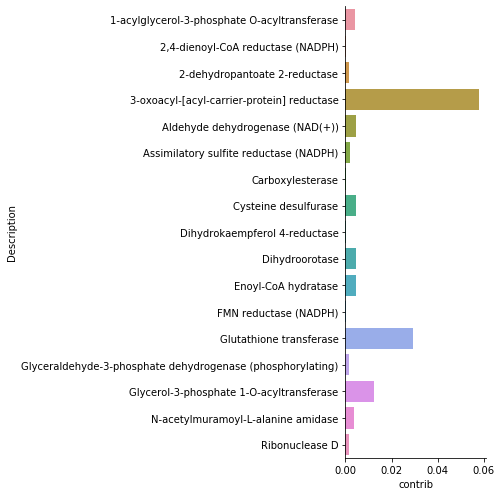

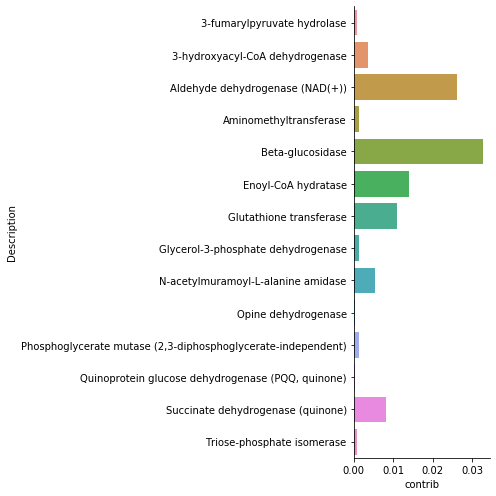

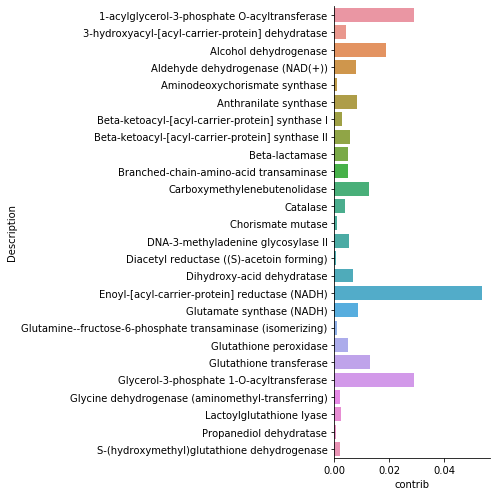

In [88]:
for mesysi in metabosystems:
    sns.catplot(x='contrib', y="Description", kind="bar", data=discriminatory_reactions[mesysi], order = discriminatory_reactions[mesysi].loc[:,'Description'].sort_values(), height = 7);

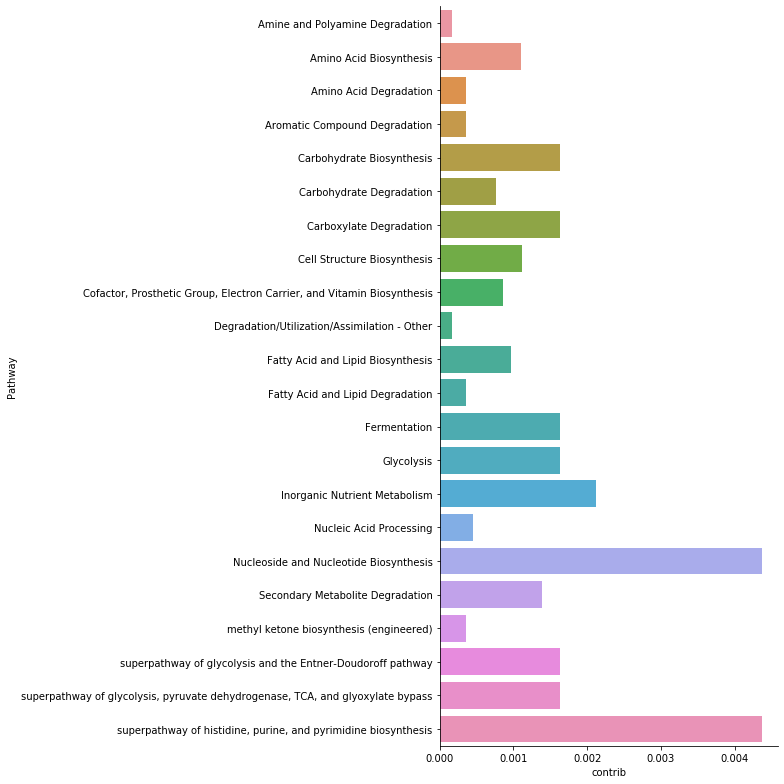

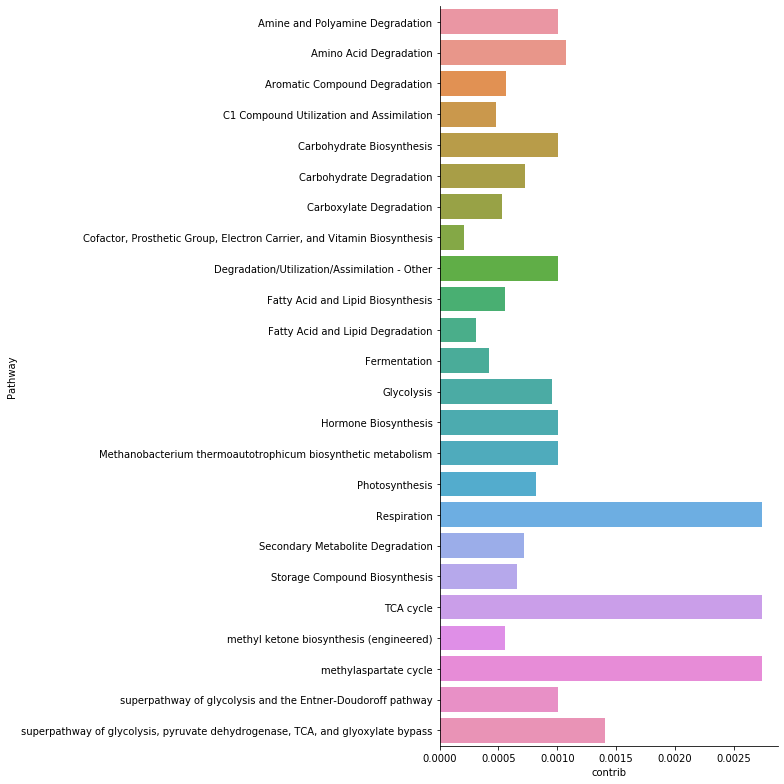

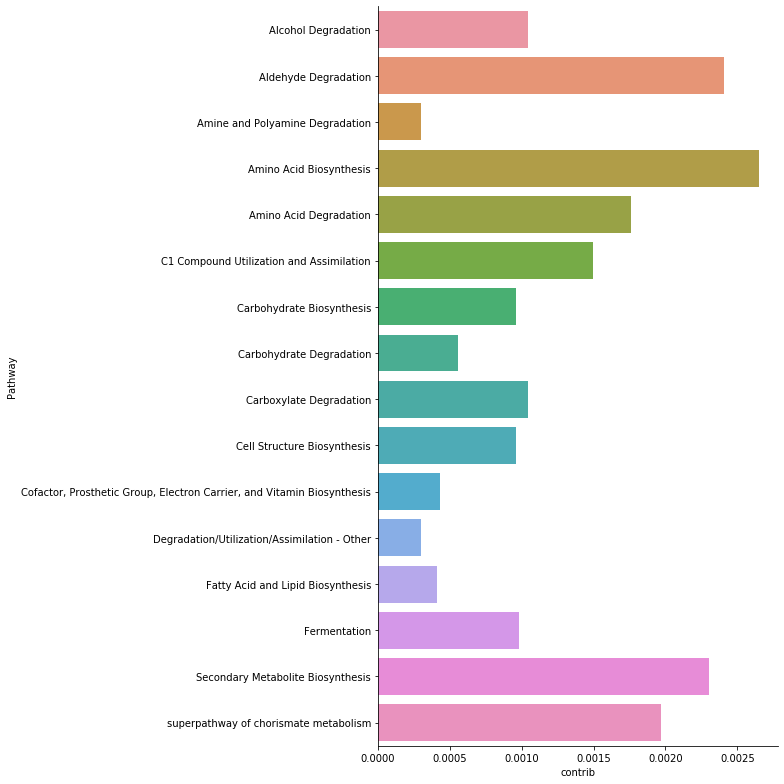

In [94]:
for mesysi in metabosystems:
    sns.catplot(x='contrib', y="Pathway", kind="bar", data=discriminatory_pathways[mesysi], order = discriminatory_pathways[mesysi].loc[:,'Pathway'].sort_values(), height = 11);

In [2]:
def load_metabosystems(runs):
    metabosystems = {}
    for run in runs:
        metabosystems[run] = pd.read_csv(biomenet_taxon_results+run+'/metabosystem_contrib.tsv', sep = '\t')
        metabosystems[run].set_index('taxon', inplace = True)
    
    return metabosystems

def cluster_pca_taxons(runs, metsys_dict):
    pca_dict = {}
    labels = {}
    clusters_dict = {}
    scores = {}
    for run in runs:
        pca = PCA(n_components = 2)
        pca_dict[run] = pca.fit_transform(metsys_dict[run])
        
        labels[run] = AffinityPropagation(max_iter = 500, verbose = True, convergence_iter = 50).fit_predict(pca_dict[run])
        clusters_dict[run] = pd.DataFrame(columns = metsys_dict[run].columns)
        
        for i in np.unique(labels[run]):
            clust_filter = labels[run] == i
            clusters_dict[run].loc[i, :] = metsys_dict[run].loc[clust_filter].mean()
            
        scores[run] = pdist(clusters_dict[run].to_numpy()).mean()/pdist(np.array(([1,0,0],[0,1,0],[0,0,1]))).mean()
    return pca_dict, clusters_dict, labels, scores

def plot_cluster_taxons(run, metsys_dict, labels, pca_results):
    color = pd.Series(labels[run], index = metsys_dict[run].index)
    cmap = ListedColormap(sns.color_palette("husl", len(np.unique(labels[run]))).as_hex())
    fig_pca, ax = plot.subplots(ncols = 1, nrows = 1)
    ax.scatter(pca_results[run][:,0], pca_results[run][:,1] , c = color, cmap = cmap )
    
def triplot_cluster_taxons(run, metsys_dict, labels):
    for taxon in metsys_dict[run].index:
        metsys_dict[run].loc[taxon, 'Genus'] = taxonomy.loc[taxon, 'Genus']
        metsys_dict[run].loc[taxon, 'Order'] = taxonomy.loc[taxon, 'Order']
        metsys_dict[run].loc[taxon, 'Class'] = taxonomy.loc[taxon, 'Class']
        
    pallete = dict(zip(np.unique(labels[run]), sns.color_palette("husl", 4)))
    color = pd.Series(labels[run], index = metsys_dict[run].index, dtype = 'str')
    fig1 = px.scatter_ternary(metsys_dict[run], a="V1", b="V2", c="V3", template = 'plotly_white',
                              color = color, color_discrete_map = pallete, hover_name = 'Class', hover_data = {'V1': False, 'V2': False, 'V3': False, 
                                                                                                               'Order': True, 'Genus': True})

    fig1.show()
    return fig1

def rxn_to_ec(metabosystem, rxn_dict, path):
    file = gzip.open(path+str(metabosystem)+'.tsv.gz', 'w')
    file.write(b"function\tCIR_19\n")
    for ec in rxn_dict[metabosystem].loc[:,'EC-Number'].unique():
        ec_filter = rxn_dict[metabosystem].loc[:,'EC-Number'] == ec
        contrib = rxn_dict[metabosystem].loc[ec_filter,'contrib'].sum()
        content = ec+'\t'+str(contrib*1000000)+'\n'
        file.write(content.encode())
    file.close()
    print('written EC-metagenome for '+str(metabosystem))

def annotate_rxn(metabosystem, rxn_dict):
    for rxn in rxn_dict[metabosystem].index:
        rxn_dict[metabosystem].loc[rxn, 'EC-Number'] = str(EC_reactions.loc[rxn, 'EC-Number']).replace('-', ':')
        ec = rxn_dict[metabosystem].loc[rxn, 'EC-Number']
        #rxn_dict[metabosystem].loc[rxn, 'Description'] = ec_info.loc[ec, 'Description']
    return rxn_dict

def get_major_subsystems(metabosystems, subs_df):
    major_subsystems = {}
    min_major_probability = pd.DataFrame(columns = metabosystems)
    
    for mesysi in metabosystems:
        major_filter = subs_df.loc[:, mesysi] > 3/nsubs
        major_subsystems[mesysi] = subs_df.loc[major_filter, mesysi].copy()
        min_major_probability.loc['0', mesysi] = major_subsystems[mesysi].min()
    
    return major_subsystems, min_major_probability

def get_discriminatory_subsystems(metabosystem, major_subs_dict, min_major_probability, discriminatory_susbsystems, cutoff = 1):

    disc_filter = np.log(major_subs_dict[metabosystem].loc[:]/min_major_probability.loc['0',~metabosystems.isin([metabosystem])].max()) > cutoff
    discriminatory_susbsystems[metabosystem] = major_subs_dict[metabosystem].loc[disc_filter].copy()
    

def write_rxns_dict(metabosystem, subs_dict, rxn_dict):
    rxn_dict[metabosystem] = pd.DataFrame(index = reaction_contrib.index, dtype = 'float64')
    rxn_dict[metabosystem].index.name = 'Reaction'

    for subsi in subs_dict[metabosystem].index:
        rxn_dict[metabosystem] = rxn_dict[metabosystem].join(pd.DataFrame(subs_dict[metabosystem].loc[subsi]*reaction_contrib.loc[:,subsi])) 

    rxn_dict[metabosystem] = pd.DataFrame(rxn_dict[metabosystem].sum(axis = 1))
    rxn_dict[metabosystem].rename(columns = {0:'contrib'}, inplace = True)
    rxn_dict[metabosystem].fillna(0, inplace = True)
    
    zero_filter = rxn_dict[metabosystem].loc[:,'contrib'] == 0
    rxn_dict[metabosystem].drop(rxn_dict[metabosystem][zero_filter].index, inplace = True)
    print('are reactions unique? = '+str(len(rxn_dict[metabosystem].index.unique()) == rxn_dict[metabosystem].shape[0]))
    
    return rxn_dict
           
def rxn_to_picrust_pathway(metabosystem, rxn_dict, pthwy_dict):
    temp2 = pd.DataFrame()
    for ec in rxn_dict[metabosystem].loc[:,'EC-Number'].unique():
        ec_filter = rxn_dict[metabosystem].loc[:,'EC-Number'] == ec
        temp3 = rxn_dict[metabosystem].loc[ec_filter,'contrib']
        try:
            for rxn in ec_to_metacyc.loc[ec, 'Reaction'].split(','):
                temp2.loc[rxn, 'contrib'] = temp3.sum()/len(ec_to_metacyc.loc[ec, 'Reaction'].split(','))
        except:
            print(metabosystem+' '+rxn)

    temp4 = {}
    for rxn in temp2.index:
        path_filter = metacyc_pathways['Reactions'].str.contains(rxn)
        for pathway in metacyc_pathways.loc[path_filter].index:
            if pathway not in temp4.keys():
                temp4[pathway] = [temp2.loc[rxn, 'contrib']]
            else:
                temp4[pathway].append(temp2.loc[rxn, 'contrib'])
    
    temp = pd.DataFrame()
    for pathway in temp4.keys():
        temp.loc[pathway, 'contrib'] = gmean(temp4[pathway])
        temp.loc[pathway, 'Description'] = metacyc_pathways.loc[pathway, 'Description']
        
    pthwy_dict[metabosystem] = pd.DataFrame()
    for pathway in temp.loc[:, 'Description'].unique():
        path_filter = temp.loc[:, 'Description'] == pathway
        pthwy_dict[metabosystem].loc[pathway, 'contrib'] = gmean(temp.loc[path_filter, 'contrib'])

    pthwy_dict[metabosystem].index.name = 'Pathway'
    pthwy_dict[metabosystem].reset_index(inplace = True)

def write_rxns_df(metabosystems, subs_dict):
    rxn_df = pd.DataFrame(index = reaction_contrib.index, columns = metabosystems, dtype = 'float64')
    rxn_df.index.name = 'Reaction'
    for mesysi in metabosystems:
        rxns = pd.DataFrame(index = reaction_contrib.index, dtype = 'float64')
        rxns.index.name = 'Reaction'
        for subsi in subs_dict[mesysi].index:
            rxns = rxns.join(pd.DataFrame(subs_dict[mesysi].loc[subsi]*reaction_contrib.loc[:,subsi])) 
        rxn_df.loc[:, mesysi] = rxns.sum(axis = 1)     
    return rxn_df

def plot_pathway_heatmap(pathwy_df, cmap = sns.cubehelix_palette(16, start = 2.1, rot = -0.2, gamma = 0.4, hue = 1, light = 0.8, dark = 0.2, as_cmap = True)):
    row_linkage = linkage(pdist(pathwy_df.to_numpy()), method = "ward", optimal_ordering = True)
    row_cluster = fcluster(row_linkage, 4, criterion = 'maxclust')
    fun_palette = dict(zip(np.unique(row_cluster), 
                           sns.color_palette("Paired", len(np.unique(row_cluster)))))
    fun_color = pd.Series(row_cluster, 
                          index = pathwy_df.index, name = 'clusters').map(fun_palette)
    row_color = pd.DataFrame(fun_color)

    #hierarchical clustering on taxons
    col_linkage = linkage(pdist(pathwy_df.T.to_numpy()), 
                          method = "weighted", optimal_ordering = True)

    fig_heatmap = sns.clustermap(pathwy_df, row_linkage = row_linkage, 
                                     col_linkage = col_linkage, cmap = cmap, 
                                     cbar_kws = {'orientation':'horizontal'}, 
                                     cbar_pos=(0.05, 1.01, 0.4, 0.02), method = "weighted",
                                     row_colors = row_color, dendrogram_ratio=0.05, 
                                     colors_ratio=0.02, yticklabels = True)
    
    return fig_heatmap

def load_unstrat_pathway(path):
    #Load pathway abundance by sample
    pthwy_df = pd.read_csv(path, compression = 'gzip', sep = '\t')
    pthwy_df.set_index('pathway', inplace = True)
    
    pathway_unstrat = {}
    #Load bottom level description
    bottom_level = pd.read_csv('/home/alexis/UAM/picrust/default_files/metacyc_pathways_info.txt.gz', compression = 'gzip', sep = '\t', names = ['pathway', 'description'])
    bottom_level.set_index('pathway', inplace = True)
    #Load second level description
    second_level = pd.read_csv('/home/alexis/UAM/picrust/default_files/metacyc_pathways_info_prokaryotes_sec_level.tsv', sep = '\t', names = ['pathway', 'description'])
    second_level.set_index('pathway', inplace = True)
    
    #Annotate bottom level pathways
    pathway_unstrat['bottom_level'] =  pthwy_df.join(bottom_level)
    pathway_unstrat['bottom_level'].set_index('description', inplace = True)
    #Calculate centered log-ratio
    pathway_unstrat['bottom_level_clr'] = pathway_unstrat['bottom_level'].copy()
    pathway_unstrat['bottom_level_clr'].loc[:,:] = pathway_unstrat['bottom_level_clr'].loc[:,:] + 0.00001
    for sample in pathway_unstrat['bottom_level_clr'].columns:
        pathway_unstrat['bottom_level_clr'].loc[:,sample] = clr(pathway_unstrat['bottom_level_clr'].loc[:,sample])
       
    pathway_unstrat['bottom_level_clr'].index.name = 'pathway'
    pathway_unstrat['bottom_level'].index.name = 'pathway'
    #Annotate second level pathways
    temp_2ndlvl = pthwy_df.join(second_level)
    #Sum pathways with the same second level annotation
    pathway_unstrat['second_level'] = pd.DataFrame(index = temp_2ndlvl.loc[:,'description'].unique(), columns = pathway_unstrat['bottom_level'].columns, dtype = 'float64')
    for pathway in pathway_unstrat['second_level'].index:
        path_filter = temp_2ndlvl.loc[:, 'description'] == pathway 
        for sample in pathway_unstrat['second_level'].columns:
            pathway_unstrat['second_level'].loc[pathway, sample] = temp_2ndlvl.loc[path_filter, sample].sum()
    #Calculate centered log-ratio of second level pathways
    pathway_unstrat['second_level_clr'] = pathway_unstrat['second_level'].copy()
    pathway_unstrat['second_level_clr'].loc[:,:] = pathway_unstrat['second_level_clr'].loc[:,:] + 10
    for sample in pathway_unstrat['second_level_clr'].columns:
        pathway_unstrat['second_level_clr'].loc[:,sample] = clr(pathway_unstrat['second_level_clr'].loc[:,sample])   
    
    pathway_unstrat['second_level_clr'].index.name = 'pathway'
    pathway_unstrat['second_level'].index.name = 'pathway'
    return pathway_unstrat